In [1]:
%pylab inline
%matplotlib inline
import numpy as np      # for math
#import json             # for managing json files
#import subprocess       # for launching processes
import pandas as pd     # for managing dataframes
import os.path

Populating the interactive namespace from numpy and matplotlib


In [2]:
#http://www.aaai.org/ocs/index.php/FLAIRS/2009/paper/viewFile/123/338

In [3]:
class Combinations_probability:
    def __init__(self):
        filename = "./data/combinations_probability.csv"
        if not(os.path.exists(filename)):
            os.mkdir("data")
            self.__create_combinations_probability().to_csv(filename, index=False)
        self.df = pd.read_csv(filename,low_memory=False, sep=',')
        self.df.rename(columns=lambda x: int(x) if x.isdigit() else x, inplace=True)
        self.num_occurrences = float(self.df["occurrences"].sum())
        return

    def __create_combinations_probability(self):
        res = self.__get_df_dices_occurrences(6, 4, 100000)
        self.__set_couples_sum(res)
        self.__increment_couples(res)
        return res
    
    def __get_df_dices_occurrences(self, base, size, repetitions):
        res = self.__get_df_unique_combinations(base, size)
        res["occurrences"] = 0
        repetition = 0
        while repetition < repetitions:
            rand = sort(np.random.random_integers(1, high=base, size=size))
            res.loc[self.__condition_dices(res, rand), "occurrences"] += 1
            repetition += 1
        return res
    
    def __get_df_unique_combinations(self, base, size):
        return pd.DataFrame(self.__get_unique_combinations(base, size), columns=["dice_"+str(x+1) for x in range(size)])
    
    def __get_unique_combinations(self, base, size):
        init = [0]*size
        res = [[x+1 for x in init]]
        max_sum = size*(base-1)
        while sum(init) != max_sum:
            init[0] = (init[0] + 1)%base
            index = 0
            while init[index] == 0: 
                index = index + 1
                init[index] = (init[index] + 1)%base
            while index != 0:
                init[index-1] = init[index]
                index = index - 1
            res = res + [[x+1 for x in init[::-1]]]
        return res
    
    def __condition_dices(self, df, dices):
        cond = True
        for index, dice in enumerate(dices):
            cond = (cond & (df["dice_"+str(index+1)] == dice))
        return cond
    
    def __set_couples_sum(self, df):
        min_sum = 2 
        max_sum = 12 
        for index in range(min_sum, max_sum+1):
            df[index] = 0
        return
    
    def __increment_couples(self, df):
        for i in df.index:
            for sm in self.__get_couples_sum([ df.ix[i, "dice_1"], df.ix[i, "dice_2"], df.ix[i, "dice_3"], df.ix[i, "dice_4"] ]):
                df.ix[i, sm] = 1
        return

    def __get_couples_sum(self, dices):
        sums = []
        for i in range(3):
            sums += [dices[3]+dices[2-i]]
            sums += [sum(dices) - (dices[3]+dices[2-i])]
        return sums

    def get_probability_to_roll(self, lst):
        #if len(lst) < 3:
        #    return 1.0
        return self.df[self.__condition_sums(lst)]["occurrences"].sum()/self.num_occurrences
        #return self.__condition_sums(lst)/self.num_occurrences
        
    def __condition_sums(self, sums_in):#, sums_out=[]):
        cond = False
        #for index, sm in enumerate(sums_in):
        #    cond = (cond | (self.df[sm] == 1))
        for sm in sums_in:
            cond = (cond | (self.df[sm] == 1))
        #for index, sm in enumerate(sums_out):
        #    cond = (cond & (df[sm] == 1))
        return cond
        
    def get_probability_to_roll_exclusive(self, lst):
        return self.df[self.__condition_sums_exclusive(lst)]["occurrences"].sum()/self.num_occurrences
    
    def __condition_sums_exclusive(self, sums_in):
        cond = True
        for sm in [x for x in range(2,13) if x not in sums_in]:
            cond = (cond & (self.df[sm] == 0))
        return cond & (self.__condition_sums(sums_in))

    


In [4]:
probs = Combinations_probability()

In [5]:
print probs.get_probability_to_roll([5])
#print probs.get_probability_to_roll([6])
print probs.get_probability_to_roll([5,6])
#print probs.get_probability_to_roll([4,5])
print probs.get_probability_to_roll([6,7,8])
print probs.get_probability_to_roll_exclusive([4])
print probs.get_probability_to_roll_exclusive([6])
print probs.get_probability_to_roll_exclusive([4,6])

0.44722
0.73181
0.91915
0.00077
0.00067
0.00752


game simulation

In [6]:
class Cantstop:
    def __init__(self, num_players):
        self.num_players = num_players        # number of players
        self.board = [[0 for x in range(11)] for y in range(num_players)]# status of the board for each player
        self.points = [0]*num_players         # points scored by each player, i.e. number of filled columns
        self.full = []                        # list of full columns, not playable anymore
        self.playing = 0                      # index of the player who is playing the game
        self.turns = 0                        # number of turns played
        self.available_moves = []             # legal moves available to the player
        self.player_neutral = [0]*3           # status of the neutral markers for the current player
        self.player_board =  [0]*11           # status of the board for the current player
        self.player_full = []                 # list of full columns, not playable anymore, for the current player
        self.player_points = 0                # points of the current player
        return
    
    def __get_dices_sum(self, dices):
        sums = []
        for i in range(3):
            sums += [ [dices[3]+dices[2-i] , sum(dices) - (dices[3]+dices[2-i])] ]
        return sums
    
    def __extract_next_move(self):
        #moves = self.__get_dices_sum(np.random.random_integers(1, high=6, size=4))
        #print moves
        return self.__get_dices_sum(np.random.random_integers(1, high=6, size=4))
    
    def __get_legal_move(self, move):
        move = [x for x in move if x not in self.player_full]
        neutral = [x for x in self.player_neutral if x!=0]
        if len(neutral) <= 1:
            return [move]
        if len(neutral) == 3:
            return [[x for x in move if x in neutral]]
        if len([x for x in move if x in neutral]) >= 1:
            return [move]
        else:
            return [[x] for x in move]
        return
    
    def __next_move(self):
        moves = self.__extract_next_move()
        #print moves
        legal_moves = []
        for move in moves:
            #legal_moves += self.__get_legal_move(move)
            legal_move = self.__get_legal_move(move)
            if legal_move != [[]]:
                legal_moves += legal_move
        return legal_moves
    
    def __update_neutral(self, column):
        index = 0
        while self.player_neutral[index] not in [0,column]:
            index += 1
        if self.player_neutral[index] == 0:
            self.player_neutral[index] = column
        #print "__updated neutral:", self.player_neutral
        return
    
    def __is_full(self, column):
        return self.player_board[column-2] >= (2*(7 - abs(7 - column)) - 1)
    
    def __next_player(self):
        # change player
        self.playing = (self.playing+1)%self.num_players
        # reset game variables
        for index in range(len(self.player_neutral)):
            self.player_neutral[index] = 0
        for index in range(len(self.player_board)):
                self.player_board[index] = self.board[self.playing][index]
        self.player_full = self.full[:]
        self.player_points = self.points[self.playing]
        # update game turn
        self.turns += 1
        return
    
    def start(self):
        # set random first player
        self.playing = np.random.randint(self.num_players)
        # get next move
        self.available_moves = self.__next_move()
        return
    
    # next move chosen and continue
    def move(self, index, cont):
        if self.available_moves == []:
            return []
        # update move
        for column in self.available_moves[index]:
            #self.board[self.playing][column-2] += 1
            self.player_board[column-2] += 1
            self.__update_neutral(column)
        # check if last move has filled some column
        for column in set(self.available_moves[index]):
            if self.__is_full(column):
                self.player_full += [column]
                self.player_points += 1
                # check if winning condition
                if self.player_points >= 3:
                    self.available_moves = []
                    self.points[self.playing] = self.player_points
                    self.full = self.player_full[:]
                    for index in range(len(self.player_board)):
                        self.board[self.playing][index] = self.player_board[index]
                    return []
        # continue or stop?
        if cont: # continue
            # get next move
            self.available_moves = self.__next_move()
        else: # stop
            # update board
            for index in range(len(self.player_board)):
                self.board[self.playing][index] = self.player_board[index]
                #self.player_board[index] = 0
            self.points[self.playing] = self.player_points
            self.full = self.player_full[:]
            # empty next move
            self.available_moves = []
        # change player if no move available
        while self.available_moves == []:
            self.__next_player()
            self.available_moves = self.__next_move()
        return [self.playing, self.available_moves]
    
    def reset(self):
        for i in range(len(self.board)):
            for j in range(len(self.board[i])):
                self.board[i][j] = 0
        for i in range(len(self.points)):
            self.points[i] = 0
        self.full = []
        self.playing = 0
        self.turns = 0
        self.available_moves = []
        for i in range(len(self.player_neutral)):
            self.player_neutral[i] = 0
        for i in range(len(self.player_board)):
            self.player_board[i] = 0
        self.player_full = []
        self.player_points = 0
        return
    

In [7]:
from IPython import display
import time

def plot_board(cantstop):
    colors = ["red","blue","green","orange"]
    width = 1.0/cantstop.num_players
    #fig, ax = plt.subplots()
    n = array(range(2,13))
    # plot max result
    plt.bar(n, [(2*(7 - abs(7 - column)) - 1) for column in n], align="center", width=1.0, color="black",alpha=0.3, label="_back")
    # plot neutral markers of current player
    #plt.bar(n-(width*(cantstop.playing)), cantstop.player_board, align="edge", width=width, color=colors[cantstop.playing] ,alpha=0.5)
    plt.bar(n-0.5+(width*(cantstop.playing)), cantstop.player_board, align="edge", width=width, color=colors[cantstop.playing] ,alpha=0.5)
    # plot all players
    for index, (player_board, color) in enumerate(zip(cantstop.board,colors)):
        #plt.bar(n-(width*(index)), player_board, align="edge", width=width, alpha=0.5, color=color)
        plt.bar(n-0.5+(width*(index)), player_board, align="edge", width=width, alpha=1.0, color=color, label="_player")
    # legend: current player
    plt.bar([0], [0], width=0, color=colors[cantstop.playing], label="player "+str(cantstop.playing))
    plt.legend()
    #plt.show()
    return

def play_cantstop(cantstop, players, show=False):
    #x = Cantstop(len(players))
    #player = Player_random()
    cantstop.start()
    while cantstop.available_moves != []:
        res = players[cantstop.playing].move(cantstop.available_moves, cantstop)
        cantstop.move(res[0], res[1])
        if show:
            plt.gca().cla() 
            plot_board(cantstop)
            display.clear_output(wait=True)
            display.display(plt.gcf()) 
            time.sleep(0.01)
    return [cantstop.playing, cantstop.turns]

def test_play_cantstop(players, show=False):
    x = Cantstop(len(players))
    return play_cantstop(x, players, show)

def multiple_play_cantstop(players, plays):
    wins = [0] * len(players)
    turns = []
    cantstop = Cantstop(len(players))
    for play in range(plays):
        [last_winner, last_turns] = play_cantstop(cantstop, players, False)
        cantstop.reset()
        # save results
        wins[last_winner] += 1
        turns += [last_turns]
    return [wins, turns]


In [8]:
class Player_easy(object):
    def move(self, available_moves, cantstop):
        return [0, False]

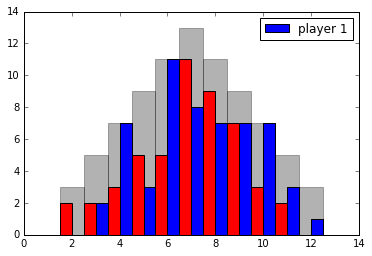

win player 1 in 54 turns


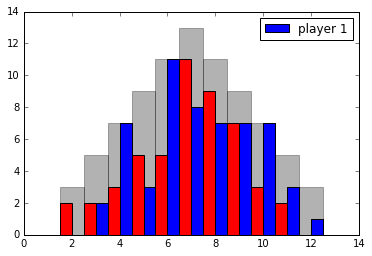

In [9]:
res = test_play_cantstop([Player_easy(),Player_easy()], True)
#test_play_cantstop()
print "win player", res[0], "in", res[1], "turns"

In [10]:
##############################
#
# player who chooses the next move randomly
#
##############################

class Player_random(object):
    def move(self, available_moves, cantstop):
        chosen_move_index = self.__get_next_move_index(available_moves, cantstop)
        new_player_neutral = self.__get_new_player_neutral(cantstop.player_neutral, available_moves[chosen_move_index])
        if_continue = self.__get_if_continue(new_player_neutral, cantstop)
        return [chosen_move_index, if_continue]
    
    def __get_next_move_index(self, available_moves, cantstop):
        return np.random.random_integers(0, high=len(available_moves)-1)
    
    def __get_new_player_neutral(self, player_neutral, next_moves):
        new_player_neutral = player_neutral[:]
        for column in next_moves:
            index = 0
            while new_player_neutral[index] not in [0,column]:
                index += 1
            if new_player_neutral[index] == 0:
                new_player_neutral[index] = column
        return new_player_neutral
    
    def __get_if_continue(self, new_player_neutral, cantstop):
        cont = True
        if 0 not in new_player_neutral:
            cont = (np.random.random_sample() >= probs.get_probability_to_roll(new_player_neutral))
            #cont = (np.random.random_sample() <= 0.2)
        return cont

##############################
#
# player who chooses as next move the most probable one
#
##############################
    
class Player_greedy(object):
    def move(self, available_moves, cantstop):
        chosen_move_index = self.__get_next_move_index(available_moves, cantstop)
        new_player_neutral = self.__get_new_player_neutral(cantstop.player_neutral, available_moves[chosen_move_index])
        if_continue = self.__get_if_continue(new_player_neutral, cantstop)
        return [chosen_move_index, if_continue]
    
    def __get_next_move_index(self, available_moves, cantstop):
        chosen_move_index = 0
        chosen_player_neutral = [x for x in self.__get_new_player_neutral(cantstop.player_neutral, available_moves[0]) if x != 0]
        #chosen_player_neutral_zeros = len([x for x in chosen_player_neutral if x == 0])
        for index, move in enumerate(available_moves[1:]):
            new_player_neutral = [x for x in self.__get_new_player_neutral(cantstop.player_neutral, available_moves[index]) if x != 0]
            #new_player_neutral_zeros = len([x for x in new_player_neutral if x == 0])
            #if new_player_neutral_zeros > chosen_player_neutral_zeros:
            if (len(new_player_neutral) < len(chosen_player_neutral)) | (len(new_player_neutral) == len(chosen_player_neutral)) & (probs.get_probability_to_roll(new_player_neutral) > probs.get_probability_to_roll(chosen_player_neutral)):
                chosen_player_neutral = new_player_neutral[:]
                chosen_move_index = index
                #chosen_player_neutral_zeros = new_player_neutral_zeros
            #elif (new_player_neutral_zeros == chosen_player_neutral_zeros) & (probs.get_probability_to_roll()):
            #elif (len(new_player_neutral) == len(chosen_player_neutral)) & (probs.get_probability_to_roll(new_player_neutral) > probs.get_probability_to_roll(chosen_player_neutral)):
        return chosen_move_index
    
    def __get_new_player_neutral(self, player_neutral, next_moves):
        new_player_neutral = player_neutral[:]
        for column in next_moves:
            index = 0
            while new_player_neutral[index] not in [0,column]:
                index += 1
            if new_player_neutral[index] == 0:
                new_player_neutral[index] = column
        return new_player_neutral
    
    def __get_if_continue(self, new_player_neutral, cantstop):
        cont = True
        if 0 not in new_player_neutral:
            cont = (np.random.random_sample() >= probs.get_probability_to_roll(new_player_neutral))
            #cont = (np.random.random_sample() <= 0.2)
        return cont

##############################
#
# player who uses Rule of 28
#
##############################

class Player_rule28(object):
    def move(self, available_moves, cantstop):
        chosen_move_index = self.__get_next_move_index(available_moves, cantstop)
        new_player_neutral = self.__get_new_player_neutral(cantstop.player_neutral, available_moves[chosen_move_index])
        if_continue = self.__get_if_continue(new_player_neutral, available_moves[chosen_move_index], cantstop)
        return [chosen_move_index, if_continue]
    
    def __get_next_move_index(self, available_moves, cantstop):
        chosen_move_index = 0
        chosen_score = 0
        old_player_neutral = [x for x in cantstop.player_neutral if x != 0]
        for index, move in enumerate(available_moves):
            new_score = self.__get_move_score(old_player_neutral, [x for x in self.__get_new_player_neutral(cantstop.player_neutral, available_moves[index]) if x != 0])
            if (new_score > chosen_score):
                chosen_score = new_score
                chosen_move_index = index
        return chosen_move_index
    
    #def get_move_score(self, old_player_neutral, new_player_neutral):
    #    return self.__get_move_score(old_player_neutral, new_player_neutral)
    
    def __get_move_score(self, old_player_neutral, new_player_neutral):
        score = 0
        for col in set(new_player_neutral):
            p = len([x for x in new_player_neutral if x == col])
            score += p*(6 - abs(7 - col))
            if not(col in old_player_neutral):
                score += -6*p
        return score
    
    def __get_new_player_neutral(self, player_neutral, next_moves):
        new_player_neutral = player_neutral[:]
        for column in next_moves:
            index = 0
            while new_player_neutral[index] not in [0,column]:
                index += 1
            if new_player_neutral[index] == 0:
                new_player_neutral[index] = column
        return new_player_neutral
    
    def __get_if_continue(self, new_player_neutral, next_moves, cantstop):
        player_progress = [x-y for x,y in zip(cantstop.player_board, cantstop.board[cantstop.playing])]
        for move in next_moves:
            player_progress[move-2] += 1
        return (self.__get_continue_score(new_player_neutral, player_progress) < 28)
    
    def get_continue_score(self, new_player_neutral, player_progress):
        return self.__get_continue_score(new_player_neutral, player_progress)
    
    def __get_continue_score(self, new_player_neutral, player_progress):
        score = 0
        for col in new_player_neutral:
            s = player_progress[col-2]
            score += (s+1)*(abs(7-col)+1)
        if all([(x%2)==0 for x in new_player_neutral]):
            score += -2
        elif all([(x%2)==1 for x in new_player_neutral]):
            score += 2
        return score
    
##############################
#
# player who select next move with Rule of 28 but continues according to probability
#
##############################
    
class Player_rule28_prob(object):
    def move(self, available_moves, cantstop):
        chosen_move_index = self.__get_next_move_index(available_moves, cantstop)
        new_player_neutral = self.__get_new_player_neutral(cantstop.player_neutral, available_moves[chosen_move_index])
        if_continue = self.__get_if_continue(new_player_neutral, cantstop)
        return [chosen_move_index, if_continue]
    
    def __get_next_move_index(self, available_moves, cantstop):
        chosen_move_index = 0
        chosen_score = 0
        old_player_neutral = [x for x in cantstop.player_neutral if x != 0]
        for index, move in enumerate(available_moves):
            new_score = self.__get_move_score(old_player_neutral, [x for x in self.__get_new_player_neutral(cantstop.player_neutral, available_moves[index]) if x != 0])
            if (new_score > chosen_score):
                chosen_score = new_score
                chosen_move_index = index
        return chosen_move_index
    
    #def get_move_score(self, old_player_neutral, new_player_neutral):
    #    return self.__get_move_score(old_player_neutral, new_player_neutral)
    
    def __get_move_score(self, old_player_neutral, new_player_neutral):
        score = 0
        for col in set(new_player_neutral):
            p = len([x for x in new_player_neutral if x == col])
            score += p*(6 - abs(7 - col))
            if not(col in old_player_neutral):
                score += -6*p
        return score
    
    def __get_new_player_neutral(self, player_neutral, next_moves):
        new_player_neutral = player_neutral[:]
        for column in next_moves:
            index = 0
            while new_player_neutral[index] not in [0,column]:
                index += 1
            if new_player_neutral[index] == 0:
                new_player_neutral[index] = column
        return new_player_neutral
    
    def __get_if_continue(self, new_player_neutral, cantstop):
        cont = True
        if 0 not in new_player_neutral:
            cont = (np.random.random_sample() >= probs.get_probability_to_roll(new_player_neutral))
            #cont = (np.random.random_sample() <= 0.2)
        return cont
    

In [11]:
#test = Player_rule28()
#print test.get_move_score([5,8], [8])
#print test.get_move_score([5,8], [5,7])
#print test.get_continue_score([4,6,10], [0,0,2,0,3,0,0,0,1,0,0])

In [12]:
#res_easy = multiple_play_cantstop([Player_easy()], 10)[1]
res_random = multiple_play_cantstop([Player_random()], 100)[1]
res_greedy = multiple_play_cantstop([Player_greedy()], 100)[1]
res_rule28 = multiple_play_cantstop([Player_rule28()], 100)[1]
res_rule28_prob = multiple_play_cantstop([Player_rule28_prob()], 100)[1]
#boxplot_test(res[1])

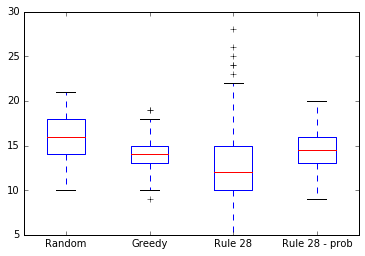

In [13]:
def boxplot_test(lst, x_labels):
    fig, ax = plt.subplots()
    ax.boxplot(lst)
    ax.set_xticklabels(x_labels)
    plt.show()
    return

#boxplot_test([res_easy, res_random, res_greedy, res_rule28], ['Easy', 'Random', 'Greedy', 'Rule 28'])
boxplot_test([res_random, res_greedy, res_rule28, res_rule28_prob], ['Random', 'Greedy', 'Rule 28', 'Rule 28 - prob'])


In [14]:
#res = test_play_cantstop([Player_random(),Player_random()])#,Player_random(),Player_random()])#, True)
res = test_play_cantstop([Player_greedy(),Player_random()])
#test_play_cantstop()
print "win player", res[0], "in", res[1], "turns"

win player 0 in 26 turns


In [15]:
res = multiple_play_cantstop([Player_greedy(),Player_rule28()], 100)
print res[0]

[38, 62]
